In [1]:
import sympy as sym
import sympy.printing as printing
from sympy.printing.latex import print_latex

import numpy as np
from scipy.optimize import minimize


def to_radian(angle):
    return angle * (np.pi / 180)


MAGNETIC_PERMEABILITY = 12.57e-7
TtoAm = 795774.715459

# Symbolic computation

There are two types of symbols in this notebook:
1. Scalar symbols 
2. Matrix symobols

Unfortunately, multiplication of 2 Matrices to get a scalar, i.e. M@M.T (dot product on (3,1) matrix) is still awkard so if we want to mix, we need to take 

```python
(M@M.T).as_explicit()[0] # <- this is [1x1] matrix,  
```
we take an explicit form of \[1x1\] matrix, in terms of all M constituents. Then we take the first element as it is 1x1 matrix, thus converting it to a scalar.

## Symbol definition

In [2]:
theta, phi, lamb, omega = sym.symbols('Theta Phi Lambda Omega')
alpha1, alpha2, gamma, mu = sym.symbols("alpha_1 alpha_2 gamma \mu")
torque_par, torque_per = sym.symbols("tau_1 tau_2")
K1, K2, J1, J2 = sym.symbols("K1 K2 J1 J2")
d1, d2 = sym.symbols("d_1 d_2")
Hoe = sym.symbols("H_oe")

Ms1, Ms2 = sym.symbols("M_s1 M_s2")

demagTensor1 = sym.MatrixSymbol("Do", 3, 3)
demagTensor2 = sym.MatrixSymbol("Dt", 3, 3)
dipoleTensor12 = sym.MatrixSymbol("No", 3, 3)
dipoleTensor21 = sym.MatrixSymbol("Nt", 3, 3)
# anisotropies
A1 = sym.MatrixSymbol("Ao", 3, 1)
A2 = sym.MatrixSymbol("At", 3, 1)

Hext = sym.MatrixSymbol("He", 3, 1)

## Dependecy variables

In [218]:
sinT = sym.sin(theta)
cosT = sym.cos(theta)

cosL = sym.cos(lamb)
sinL = sym.sin(lamb)

sinO = sym.sin(omega)
cosO = sym.cos(omega)

sinP = sym.sin(phi)
cosP = sym.cos(phi)

cosPO = sym.cos(phi - omega)
sinPO = sym.sin(phi - omega)

const1 = (gamma / Ms1) * (1 / (1 + alpha1**2))
const2 = (gamma / Ms2) * (1 / (1 + alpha2**2))

M1 = sym.Matrix([Ms1 * sinT * cosP, Ms1 * sinT * sinP, Ms1 * cosT])
M2 = sym.Matrix([Ms2 * sinL * cosO, Ms2 * sinL * sinO, Ms2 * cosL])

Hdemag1 = demagTensor1 * M1 / mu
Hdemag2 = demagTensor2 * M2 / mu

Hdipole1 = dipoleTensor21 * M1 / mu
Hdipole2 = dipoleTensor12 * M2 / mu

Hanisotropy1 = A1 * 2 * K1 * (M1.T * A1) / (
    Ms1**2)  # M1 is with Ms1 so need to divide by square
Hanisotropy2 = A2 * 2 * K2 * (M2.T * A2) / (Ms2**2)

Hiec1 = J1 * M2 / (d1 * Ms1**2)
Hiec2 = J2 * M1 / (d2 * Ms2**2)
# anisotropies = K1 * (cosT**2 + (sinT**2) *
#                      (sinP**2)) + K2 * (cosL**2 + (sinL**2) * (sinO**2))
# dipole = -M1.dot(Hdip2) - M2.dot(Hdip1)
# demag = -M1.dot(Hdemag1) - M2.dot(Hdemag2)
# ext = -M1.dot(Hext) - M2.dot(Hext)

anisotropy = -M1.T * Hanisotropy1 - M2.T * Hanisotropy2
dipole = M1.T * Hdipole2 + M2.T * Hdipole1
demag = M1.T * Hdemag1 + M2.T * Hdemag2  # dipole interactions are in filed with -, so -grad makes them +
ext = -M1.T * Hext - M2.T * Hext
iec = -M1.T * Hiec1 - M2.T * Hiec2

# energy = (anisotropies*sym.Identity(1) + dipole + demag + ext).as_explicit()[0]
energy = (anisotropy + dipole + demag + ext + iec).as_explicit()[0]
dUdP = sym.diff(energy, phi)
dUdT = sym.diff(energy, theta)
dUdO = sym.diff(energy, omega)
dUdL = sym.diff(energy, lamb)
# """
# .as_explicit to see the actual form
# """
# energy

In [198]:
# # validate the Hext as an example
# e_sub = {
#     theta: 1,
#     phi: 2,
#     lamb: 3,
#     omega: 4,
#     Ms1: 1 * TtoAm,
#     Ms2: 1 * TtoAm,
#     Hext: sym.Matrix([1, 1, 2])
# }
# ext.subs(e_sub)

# Constructing the matrix

## Angular derivatives

In [219]:
dTheta = const1 * ((-1 / sinT) * dUdP - alpha1 * dUdT -
                   (cosL * sinT - cosT * sinL * cosPO) *
                   (torque_par + alpha1 * torque_per) - (sinL * sinPO) *
                   (alpha1 * torque_par - torque_per) + Ms1 * Hoe)

In [220]:
dPhi = const1 * (
    (1 / sinT) * dUdT - (alpha1 / (sinT**2)) * dUdP + (1 / sinT) *
    (cosL * sinT - cosT * sinL * cosPO) * (alpha1 * torque_par - torque_per) -
    (1 / sinT) * (sinL * sinPO) *
    (torque_par + alpha1 * torque_per) + alpha1 * Ms1 * Hoe / sinT)

In [221]:
dLam = const2 * ((-1 / sinL) * dUdO - alpha2 * dUdL +
                 (-sinL * cosT + sinT * cosL * cosPO) *
                 (torque_par + alpha2 * torque_per) + (sinL * sinPO) *
                 (alpha2 * torque_par + torque_per) + Ms2 * Hoe)

In [222]:
dOmega = const2 * (
    (1 / sinL) * dUdL - (alpha2 / (sinL**2)) * dUdO - (1 / sinL) *
    (sinL * cosT - sinT * cosL * cosPO) * (torque_per - alpha2 * torque_par) +
    (1 / sinL) * (sinT * sinPO) *
    (torque_par - alpha2 * torque_per) + alpha2 * Ms2 * Hoe / sinL)

## The derivative matrix 

In [223]:
dM = sym.Matrix([
    [
        sym.diff(dTheta, theta),
        sym.diff(dTheta, phi),
        sym.diff(dTheta, lamb),
        sym.diff(dTheta, omega)
    ],
    [
        sym.diff(dPhi, theta),
        sym.diff(dPhi, phi),
        sym.diff(dPhi, lamb),
        sym.diff(dPhi, omega)
    ],
    [
        sym.diff(dLam, theta),
        sym.diff(dLam, phi),
        sym.diff(dLam, lamb),
        sym.diff(dLam, omega)
    ],
    [
        sym.diff(dOmega, theta),
        sym.diff(dOmega, phi),
        sym.diff(dOmega, lamb),
        sym.diff(dOmega, omega)
    ]]
)

In [224]:
# """
# This contains also the parameter order
# """
# sub = {
#     theta: 1,
#     phi: 2,
#     lamb: 3,
#     omega: 4,
#     # Hoe
#     Hoe: 2,
#     # Hext
#     Hext: sym.Matrix([1, 1, 2]),
#     # dipole 1
#     dipoleTensor12: sym.Matrix([[1, 1, 1], [1, 1, 1], [1, 1, 1]]),
#     # dipole 2
#     dipoleTensor21: sym.Matrix([[1, 1, 1], [1, 1, 1], [1, 1, 1]]),
#     # demag 1
#     demagTensor1: sym.Matrix([[0, 0, 0], [0, 0, 0], [0, 0, 1]]),
#     # demag 2
#     demagTensor2: sym.Matrix([[0, 0, 0], [0, 0, 0], [0, 0, 1]]),
#     gamma: 2.21e5,
#     alpha1: 0.035,
#     alpha2: 0.035,
#     torque_par: 1.0,
#     torque_per: 1.0,
#     Ms1: 1 * TtoAm,
#     Ms2: 1 * TtoAm,
#     # anisotropy1
#     A1: sym.Matrix([0, 0, 1]),
#     K1: 350e3,
#     # anisotropy2
#     A2: sym.Matrix([0, 0, 1]),
#     K2: 650e3,
#     # IEC,
#     J1: 1e-5,
#     J2: 1e-4,
#     # thickness
#     d1: 1e-9,
#     d2: 1e-9,
#     mu: 1
# }

# # energy.subs(sub)
# dM.evalf(subs=sub)

In [225]:
# test the function
dMFunction = sym.lambdify([list(sub.keys())], dM, "numpy")
dMFunction(list(sub.values()))

array([[-19082746463.2749, -216464094807.898, 593340167000.121,
        6881483621.14860],
       [601318713481.312, 346927821381.509, -277019402877.685,
        -3212833849.90003],
       [29713291990.6910, 57632587985.7191, -2160140621.79044,
        -472131493515.150],
       [-1791600878227.82, -3475029148388.45, 23757077869595.3,
        -360255112543.510]], dtype=object)

## The energy function and gradient

In [226]:
# energy

In [227]:
# energy.evalf(subs=sub)

In [228]:
# a vector of energy derivatives w.r.t to each of the angles
energy_gradient = sym.Matrix([
    sym.diff(energy, theta),
    sym.diff(energy, phi),
    sym.diff(energy, lamb),
    sym.diff(energy, omega),
])
energy_gradient.evalf(subs=sub)

Matrix([
[290123097604.402],
[1679599068350.08],
[1695581520693.64],
[17613007474.2936]])

In [229]:
energyFunction = sym.lambdify([list(sub.keys())], energy, "numpy")
energyGradientFunction = sym.lambdify([list(sub.keys())], energy_gradient, "numpy")
print(energyGradientFunction(list(sub.values())))

[[290123097604.402]
 [1679599068350.08]
 [1695581520693.64]
 [17613007474.2936]]


## Numerical optimisations

In [230]:
# x0 = {
#     theta: to_radian(88),
#     phi: to_radian(45),
#     lamb: to_radian(88),
#     omega: to_radian(45),
#     # Hoe
#     Hoe: 397.88,
#     # Hext
#     Hext: np.array([[1], [1], [2]]),
#     # dipole 1
#     dipoleTensor12: np.array([[0, 0, 0], [1, 1, 1], [1, 1, 1]]),
#     # dipole 2
#     dipoleTensor21: np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]]),
#     # demag 1
#     demagTensor1: np.array([[0, 0, 0], [0, 0, 0], [0, 0, 1]]),
#     # demag 2
#     demagTensor2: np.array([[0, 0, 0], [0, 0, 0], [0, 0, 1]]),
#     gamma: 2.21e5,
#     alpha1: 0.035,
#     alpha2: 0.035,
#     torque_par: 0.0,
#     torque_per: 0.0,
#     Ms1: 1 * TtoAm,
#     Ms2: 1 * TtoAm,
#     # anisotropy1
#     A1: np.array([[0], [0], [1]]),
#     K1: 350e3,
#     # anisotropy2
#     A2: np.array([[0], [0], [1]]),
#     K2: 650e3,
#     # IEC,
#     J1: 1e-5,
#     J2: 1e-4,
#     # thickness
#     d1: 1e-9,
#     d2: 1e-9,
#     mu: 1
# }
# energyGradientFunction(list(x0.values()))

array([[-1.80939000e+12],
       [ 6.48103904e+11],
       [-1.36160936e+12],
       [ 1.34166443e-04]])

# Numerical computation

In [237]:
def opt_wrapper_cost(x, args):
    theta, phi, lamb, omega = x
    return energyFunction([theta, phi, lamb, omega] + args)


def opt_wrapper_grad(x, args):
    theta, phi, lamb, omega = x
    return energyGradientFunction([theta, phi, lamb, omega] + args)


def to_radian(angle):
    return angle * (np.pi / 180)


def get_tensor_interaction(M, N):
    return N @ M


def cartiesian_from_spherical(r, inplane, azimuth):
    return np.array([
        r * np.sin(azimuth) * np.cos(inplane),
        r * np.sin(azimuth) * np.sin(inplane), r * np.cos(azimuth)
    ])


"""
        Spherical coords
        Theta -- azimuth angle, L1
        Phi -- inplane angle, L1
        Lambda -- azimuth angle, L2
        Omega -- inplane angle, L2
"""

x0 = {
    theta: to_radian(90),
    phi: to_radian(45),
    lamb: to_radian(90),
    omega: to_radian(45),
}

hext = np.expand_dims(cartiesian_from_spherical(0.4 * TtoAm, 45, 45), 0).T

arg_set = {
    # Hoe
    Hoe: 0.0,
    # Hext
    Hext: hext,
    # dipole 1
    dipoleTensor12: np.array([[0, 0, 0], [0, 0, 0], [0, 0, 0]]),
    # dipole 2
    dipoleTensor21: np.array([[0, 0, 0], [0, 0, 0], [0, 0, 0]]),
    # demag 1
    demagTensor1: np.array([[0, 0, 0], [0, 0, 0], [0, 0, 1]]),
    # demag 2
    demagTensor2: np.array([[0, 0, 0], [0, 0, 0], [0, 0, 1]]),
    gamma: 2.21e5,
    alpha1: 0.035,
    alpha2: 0.035,
    torque_par: 0.0,
    torque_per: 0.0,
    Ms1: 1,
    Ms2: 1,
    # anisotropy1
    A1: np.array([[0], [0], [1]]),
    K1: 728e3,
    # anisotropy2
    A2: np.array([[1], [0], [1]]),
    K2: 305e3,
    # IEC,
    J1: 1e-5,
    J2: 1e-9,
    # thickness
    d1: 1e-9,
    d2: 1e-9,
    mu: MAGNETIC_PERMEABILITY
}

bounds = [(0, np.pi * 2) for i in range(len(x0))]
res = minimize(opt_wrapper_cost,
               list(x0.values()),
               bounds=bounds,
               args=list(arg_set.values()),
               jac=opt_wrapper_grad,
               tol=1e-4)
res

      fun: -1991590.9454716626
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([[ 2.61361539e+05],
       [ 0.00000000e+00],
       [-5.64350152e+01],
       [-4.08032454e+01]])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 8
      nit: 6
     njev: 8
   status: 0
  success: True
        x: array([0.        , 4.46618154, 1.04945942, 0.12737148])

# VSD scan

In [244]:
from tqdm.notebook import tqdm


def find_resonance(Hstart=-1, Hstop=1, N=50):
    x0 = {
        theta: to_radian(90),
        phi: to_radian(45),
        lamb: to_radian(90),
        omega: to_radian(45),
    }
    bounds = [(0, np.pi * 2) for i in range(len(x0))]
    h_space = np.linspace(Hstart, Hstop, N)
    bottom_f, top_f = [], []
    x0vals = list(x0.values())
    for h in tqdm(h_space):
        hext = np.expand_dims(cartiesian_from_spherical(h * TtoAm, 45, 45),
                              0).T
        arg_set = {
            # Hoe
            Hoe: 0.0,
            # Hext
            Hext: hext,
            # dipole 1
            dipoleTensor12: np.array([[0, 0, 0], [0, 0, 0], [0, 0, 0]]),
            # dipole 2
            dipoleTensor21: np.array([[0, 0, 0], [0, 0, 0], [0, 0, 0]]),
            # demag 1
            demagTensor1: np.array([[0, 0, 0], [0, 0, 0], [0, 0, 1]]),
            # demag 2
            demagTensor2: np.array([[0, 0, 0], [0, 0, 0], [0, 0, 1]]),
            gamma: 220880,
            alpha1: 0.01,
            alpha2: 0.01,
            torque_par: 0,
            torque_per: 0,
            Ms1: 1.07,
            Ms2: 1.07,
            # anisotropy1
#             A1: np.array([[0.34071865], [-0.08715574],
#                           [0.936116]]),
            A1: np.array([[0], [0], [1]]),
            K1: 728e3,
            # anisotropy2
#             A2: np.array([[0], [-0.0871557],
#                           [0.996195]]),  
            A2: np.array([[0], [0], [1]]),
            K2: 305e3,
            # IEC,
            J1: 1e-5,
            J2: 1e-5,
            # thickness
            d1: 1e-9,
            d2: 1e-9,
            mu: MAGNETIC_PERMEABILITY
        }
        res = minimize(opt_wrapper_cost,
                       x0vals,
                       bounds=bounds,
                       args=list(arg_set.values()),
                       jac=opt_wrapper_grad,
                       tol=1e-12)
        matrix_res = dMFunction(res.x.tolist() + list(arg_set.values()))
        eigenvalues, eigenvectors = np.linalg.eig(matrix_res)
        freqs = np.unique(np.abs(np.imag(eigenvalues)) / 2 * np.pi / 1e9)
        bottom_f.append(freqs[0])
        if len(freqs) > 1:
            top_f.append(freqs[1])
        else:
            top_f.append(freqs[0])
        x0vals = res.x.tolist()
    return h_space, bottom_f, top_f

  0%|          | 0/100 [00:00<?, ?it/s]

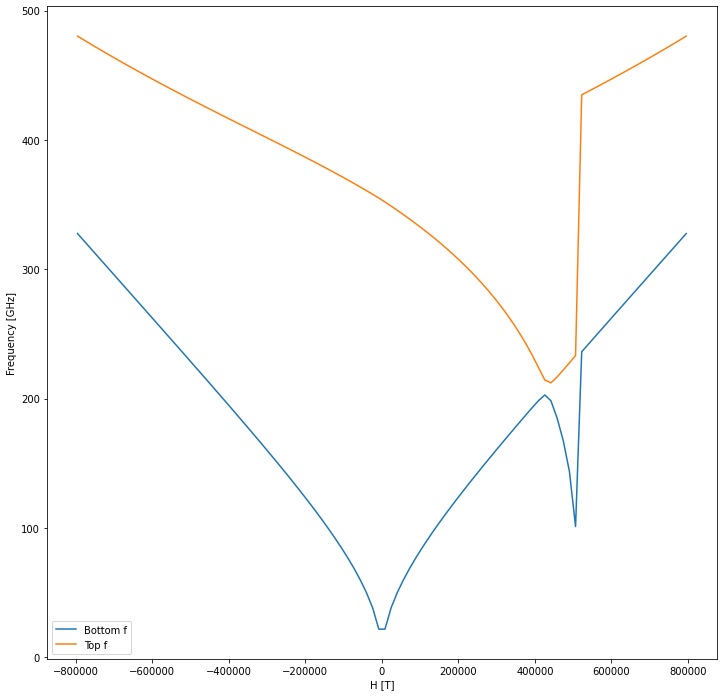

In [245]:
import matplotlib.pyplot as plt
h_space, bottom_f, top_f = find_resonance(N=100)

fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(h_space*TtoAm, bottom_f, label="Bottom f")
ax.plot(h_space*TtoAm, top_f, label="Top f")
ax.set_xlabel("H [T]")
ax.set_ylabel("Frequency [GHz]")
_ = ax.legend()